In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Create data directory paths
training_path = "data/cards/train"
testing_path = "data/cards/test"

In [3]:
# Create dataset class for monitoring preprocessing
class MainDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]
        
    @property
    def classes(self):
        return self.data.classes

In [4]:
# Confirm data loads properly
dataset = MainDataset(data_dir = training_path)

In [5]:
len(dataset)

7624

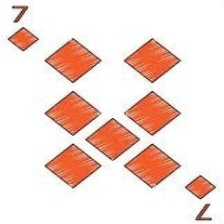

In [6]:
dataset[0]
image, label = dataset[5000]
image

In [7]:
# Create dictionary for classes to associate images with
target_to_class = {value: key for key, value in ImageFolder(training_path).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [8]:
# Create image transforms to use in ImageFolder class (could have done this earlier but wanted to test first)
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

In [9]:
# Apply image transforms to data
dataset = MainDataset(data_dir = training_path, transform = transform)

In [10]:
image, label = dataset[500]
image.shape

torch.Size([3, 200, 200])

In [11]:
# Create data loader out of dataset
dataloader = DataLoader(dataset, 
                        batch_size = 32, 
                        shuffle = True)

In [12]:
# Confirm data loader is working properly by checking shape and 
# label order (should shuffle everytime code is run)
for images, labels in dataloader:
    break

print(images.shape)
print(labels.shape)

torch.Size([32, 3, 200, 200])
torch.Size([32])


In [13]:
labels

tensor([39,  1, 31, 21, 30, 19, 31, 16, 51, 43,  6, 31, 49, 20, 29,  1,  8,  4,
         6, 18, 10, 49, 23, 29, 37,  4, 39, 35, 18, 17, 12, 18])

In [14]:
# Create the model
class Classifier(nn.Module):
    def __init__(self, num_classes = 53):
        super(Classifier, self).__init__()
        
        # Defining parts of the model
        self.base_model = timm.create_model("efficientnet_b0", pretrained = False)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        
        # Make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)
        
    def forward(self, x):

        # Connect these parts and return output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [15]:
model = Classifier(num_classes = 53)
print(str(model)[:500])

Classifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
     


In [16]:
example_out = model(images)
example_out.shape

torch.Size([32, 53])

In [17]:


# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [18]:
criterion(example_out, labels)

tensor(3.9141, grad_fn=<NllLossBackward0>)

In [19]:
# Create training/validation datasets

transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

train_folder = "data/cards/train"
val_folder = "data/cards/valid"

train_dataset = MainDataset(train_folder, transform = transform)
val_dataset = MainDataset(val_folder, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

In [20]:
# Create training loop
num_epoch = 15
train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
model = Classifier(num_classes = 53)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epoch):
    # Set model to train
    model.train()
    running_loss = 0.0
    train_n_correct = 0
    train_n_total = 0

    # Loop through training data loader
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

        _, train_predicted = torch.max(outputs.data, 1)
        train_n_total += labels.size(0)
        train_n_correct += (train_predicted == labels).sum().item()

    train_loss = round(running_loss / len(train_loader.dataset), 5)
    train_losses.append(train_loss)
    train_acc = round(train_n_correct / len(train_loader.dataset), 5)
    train_accuracy.append(train_acc)

    # Validation phase
    model.eval()
    running_loss = 0.0
    val_n_correct = 0
    val_n_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
            _, val_predicted = torch.max(outputs.data, 1)
            val_n_total += labels.size(0)
            val_n_correct += (val_predicted == labels).sum().item()
        
        val_loss = round(running_loss / len(val_loader.dataset), 5)
        val_losses.append(val_loss)
        val_acc = round(val_n_correct / len(val_loader.dataset), 5)
        val_accuracy.append(val_acc)

    # Print epoch stats
    print(f"Epoch {epoch + 1} / {num_epoch} - Train loss: {train_loss}, Validation loss: {val_loss}")
    print(f"Training Accuracy: {train_acc}, Validation accuracy: {val_acc}")

Epoch 1 / 15 - Train loss: 3.26626, Validation loss: 2.23771
Training Accuracy: 0.10939, Validation accuracy: 0.23774
Epoch 2 / 15 - Train loss: 2.21357, Validation loss: 1.54997
Training Accuracy: 0.32096, Validation accuracy: 0.48679
Epoch 3 / 15 - Train loss: 1.58576, Validation loss: 1.02231
Training Accuracy: 0.53712, Validation accuracy: 0.67547
Epoch 4 / 15 - Train loss: 1.22677, Validation loss: 0.84708
Training Accuracy: 0.63694, Validation accuracy: 0.75472
Epoch 5 / 15 - Train loss: 0.94988, Validation loss: 0.8046
Training Accuracy: 0.71078, Validation accuracy: 0.76226
Epoch 6 / 15 - Train loss: 0.73104, Validation loss: 0.74204
Training Accuracy: 0.77571, Validation accuracy: 0.78113
Epoch 7 / 15 - Train loss: 0.54339, Validation loss: 0.83572
Training Accuracy: 0.83001, Validation accuracy: 0.78868
Epoch 8 / 15 - Train loss: 0.42495, Validation loss: 0.78471
Training Accuracy: 0.87159, Validation accuracy: 0.78868
Epoch 9 / 15 - Train loss: 0.31097, Validation loss: 0.84

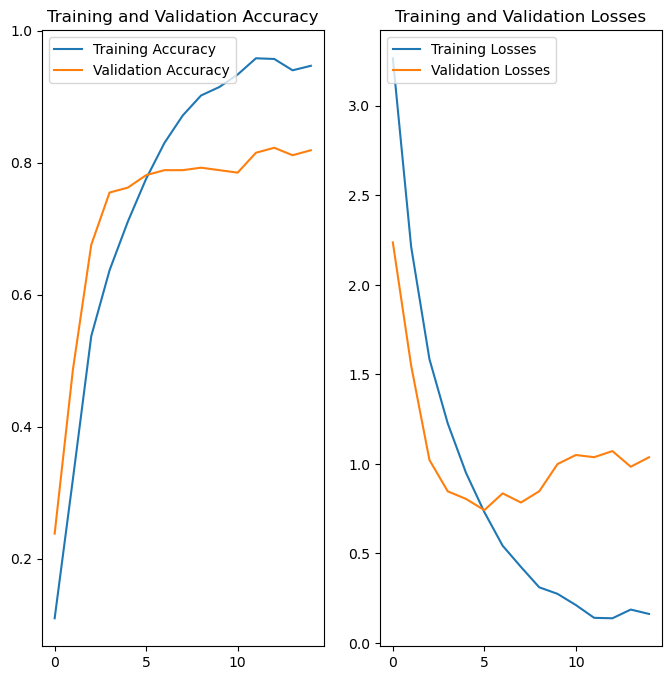

In [21]:
# Plot evaluation results
plt.figure(figsize = (8, 8))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.legend(loc = "upper left")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label = "Training Losses")
plt.plot(val_losses, label = "Validation Losses")
plt.legend(loc = "upper left")
plt.title("Training and Validation Losses")

plt.show()